# Data Science Course Capstone Project Week 4 and 5

# Week 4

---
# Decision Making for Opening a New Restaurant in Toronto
## Introduction

Sometimes we will have a question. Can we put a point on the map and know that we can start a business there? This will certainly help make the right business decisions. As a matter of fact, data can be utilized in order to aid the decision making process. Specifically, it is possible aggregate information from different neighborhoods and find out the most suitable location to start a business.

### The Problem

According to Wikipdeia, there are 140 offcially recognized neighborhoods. Supposing we would like to open a restaurant, it can be a difficult task to decide on the location to open the restaurant. Another question to be ask is the type of restaurant to be opened. Searching for the answer for this questio is even more difficult during the COVID-19 pandemic. To this end, the business question we are asking here are:

During the COVID-19 Pandemic,

1. What is the the most suitable neighborhood to start a new restarant in Toronto?
2. What should be the type of restaurant to be opened?

So, we will attempt to answer this two questions by using data and information of the neighborhoods.

### Decision Making Framework and Data Required

#### A. Decision Making Framework

Before actually collecting data to answer the above questions, it is essential to have a framwework to make the decision. In fact, the first aspect to consider is the spread of COVID-19. If there are a lot of individuals being infected in a neighborhood, there can be a regional lockdown in the neighborhood. Besides, the fear of being infectect can also hinder people to eat out. As a result, it will be a sensible decision to start a restaurant in a neighborhood with fewer COVID-19 cases. The next aspect to consider is the population in the neighborhood. The best bet here will be search for the neighborhood with higher density. This means that there will be more people in the neighborhood on average and increase the chance of getting new customers. The neighborhood itself should also be considered. Are there are different types of venues or facilities in the neighborhood? What are the different type of restaurants which are already in the neighborhood? This will help to answer the question of what type of restaurant to be opened. It will also be a bonus if the crime rate in the neighborhood is low. This will imply that the neighborhood is a safe one. People may be more willing to hang out in this case.

The decision framework can be summarized by using the following figure.

![Decision Making Framework](framework.jpg)

#### B. Data Requirements

Various types of data will be needed in this project. The data required can be gather from Toronto Open Data Portal ([https://open.toronto.ca/](https://open.toronto.ca/)). Three particular datasets will be obtained from this Open Data Portal:

1. Toronto Neighborhood Profile ([https://open.toronto.ca/dataset/neighbourhood-profiles/](https://open.toronto.ca/dataset/neighbourhood-profiles/))
2. Toronto Neighborhood Crime Rate ([https://open.toronto.ca/dataset/neighbourhood-crime-rates/](https://open.toronto.ca/dataset/neighbourhood-crime-rates/))
3. COVID-19 Cases in Toronto ([https://open.toronto.ca/dataset/covid-19-cases-in-toronto/](https://open.toronto.ca/dataset/covid-19-cases-in-toronto/))

Besides these three datasets, it is also needed to aggregate the information of different facilities, especially restaurants, of the neighborhoods. For this type of data, the Foursquare API ([https://developer.foursquare.com/](https://developer.foursquare.com/)) will be used.

*Data Aggregation and Analysis*

There are a few steps in the data analysis stage. First of all, relevant information from the datasets will be extract. For example, there is a lot of information which is not needed from the Neighborhood Profile dataset. Only data related to pouplation density will be extracted and utilized. Data extracted from the datasets of Toronto Open Data Portal will be appended to the data extracted from Foursquare.

To analyze the data, techniques of clustering analysis will be utilized. For each cluster, the mean population and number of COVID-19 cases can be obtained. Becuase, the various types of restaurants in the cluster will also be found. The results of analysis will help to make the final decision and answer the above questions.

In [15]:
import urllib.request
import pandas as pd
import numpy as np
import requests
import re

#use this to show whole dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

#### Preparation - Define the CONSTANTS for foursqure API first

In [2]:
CLIENT_ID = '02YPUXNA4OW3KBCLCVKZ1OKSCVV3R0XVHNO0YVKC3EBDRAV1' # your Foursquare ID
CLIENT_SECRET = '0OVGMVMAGOFD4PUGHMROPYJZJYPWDBSCOK1GIN34V5JCCUUK' # your Foursquare Secret
ACCESS_TOKEN = '3431NZNCVU53BOAEBV2ACSHH5UNTRUWEJZGSL1HGVTJB0G0W' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 200

#### Torontol Neigborhood Data - Extract Population Data

In [ ]:
#get the data from toronto neighborhood profile
url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e?format=csv'
filename = 'toronto_neighborhood_profile_raw.csv'
urllib.request.urlretrieve(url, filename)

In [3]:
#read the downloaded csv
toronto_neighborhood_df = pd.read_csv('toronto_neighborhood_profile_raw.csv')
toronto_neighborhood_df = toronto_neighborhood_df.iloc[:,4:]

check_rows = toronto_neighborhood_df["Characteristic"].str.contains('Population, 2016|Total private dwellings|Population density per square kilometre',case=False, regex=True)

toronto_neighborhood_df = toronto_neighborhood_df[check_rows]

toronto_neighborhood_df.set_index('Characteristic', inplace=True)
toronto_neighborhood_df.index.name = None
toronto_neighborhood_df = toronto_neighborhood_df.iloc[:,1:].T

for col in toronto_neighborhood_df.columns:
    toronto_neighborhood_df[col] = toronto_neighborhood_df.apply(lambda x: x[col].replace(",",""), axis=1)
    toronto_neighborhood_df[col] = toronto_neighborhood_df[col].astype("float64")

toronto_neighborhood_df.reset_index(inplace=True)
toronto_neighborhood_df.rename(columns={'index': 'Neighborhood'}, inplace=True)

print(toronto_neighborhood_df.shape)
toronto_neighborhood_df.head()

(140, 4)


,Neighborhood,"Population, 2016",Total private dwellings,Population density per square kilometre
0,Agincourt North,29113.0,9371.0,3929.0
1,Agincourt South-Malvern West,23757.0,8535.0,3034.0
2,Alderwood,12054.0,4732.0,2435.0
3,Annex,30526.0,18109.0,10863.0
4,Banbury-Don Mills,27695.0,12473.0,2775.0


#### Crime Rate Data

In [82]:
#get the crime rate data file
url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/3d556fc2-ddab-4aa0-97e1-227707580ec6?format=csv&projection=4326'
filename = 'toronto_neighborhood_crimerate_raw.csv'
urllib.request.urlretrieve(url, filename)

('toronto_neighborhood_crimerate_raw.csv',
 <http.client.HTTPMessage at 0x1e515e2c588>)

In [4]:
#read the downloaded csv
toronto_neighborhood_crimerate_df = pd.read_csv('toronto_neighborhood_crimerate_raw.csv')

toronto_neighborhood_crimerate_df = toronto_neighborhood_crimerate_df[ ['Neighbourhood'] + [ col for col in toronto_neighborhood_crimerate_df.filter(regex='_2019') ]]

for col in toronto_neighborhood_crimerate_df.filter(regex='(Rate_2019)').columns:
    toronto_neighborhood_crimerate_df.drop(col, axis=1, inplace=True)

toronto_neighborhood_crimerate_df.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)

toronto_neighborhood_crimerate_df["Crime Cases"] = toronto_neighborhood_crimerate_df.sum(axis = 1, skipna = True)

toronto_neighborhood_crimerate_df = toronto_neighborhood_crimerate_df[['Neighborhood', "Crime Cases"]]

print(toronto_neighborhood_crimerate_df.shape)
toronto_neighborhood_crimerate_df.head()

(140, 2)


,Neighborhood,Crime Cases
0,South Parkdale,416
1,South Riverdale,490
2,St.Andrew-Windfields,194
3,Taylor-Massey,214
4,Humber Summit,363


#### COVID-19 Cases Data

In [117]:
#get the covid-19 data file
url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/e5bf35bc-e681-43da-b2ce-0242d00922ad?format=csv'
filename = 'toronto_neighborhood_covid_raw.csv'
urllib.request.urlretrieve(url, filename)

('toronto_neighborhood_covid_raw.csv',
 <http.client.HTTPMessage at 0x1e518a60a88>)

In [5]:
#read the downloaded csv
toronto_neighborhood_covid_df = pd.read_csv('toronto_neighborhood_covid_raw.csv')
toronto_neighborhood_covid_df.rename(columns={'Neighbourhood Name': 'Neighborhood'}, inplace=True)
toronto_neighborhood_covid_df = toronto_neighborhood_covid_df[toronto_neighborhood_covid_df['Neighborhood'].notna()]
#toronto_neighborhood_covid_df = toronto_neighborhood_covid_df[toronto_neighborhood_covid_df['FSA'].notna()]

# nlist_fsa = toronto_neighborhood_covid_df.groupby("FSA")
# nlist_fsa = nlist_fsa.first()
# nlist_fsa.reset_index(inplace=True)
# nlist_fsa = nlist_fsa[["Neighborhood","FSA"]]

toronto_neighborhood_covid_df = toronto_neighborhood_covid_df.groupby("Neighborhood")["Neighborhood"].agg('count').to_frame("COVID Cases").reset_index()

#toronto_neighborhood_covid_df = pd.merge(left=toronto_neighborhood_covid_df, right=nlist_fsa, how='left', left_on='Neighborhood', right_on='Neighborhood')
toronto_neighborhood_covid_df = toronto_neighborhood_covid_df[['Neighborhood'] + [col for col in toronto_neighborhood_covid_df.columns if col != "Neighborhood"]]

print(toronto_neighborhood_covid_df.shape)
toronto_neighborhood_covid_df.head()

(140, 2)


,Neighborhood,COVID Cases
0,Agincourt North,884
1,Agincourt South-Malvern West,685
2,Alderwood,274
3,Annex,654
4,Banbury-Don Mills,564


#### Join the dataframes

In [6]:
toronto_neighborhood_df = pd.merge(left=toronto_neighborhood_df, right=toronto_neighborhood_crimerate_df, how='left', left_on='Neighborhood', right_on='Neighborhood')
toronto_neighborhood_df = pd.merge(left=toronto_neighborhood_df, right=toronto_neighborhood_covid_df, how='left', left_on='Neighborhood', right_on='Neighborhood')

toronto_neighborhood_df = toronto_neighborhood_df[["Neighborhood"] + [col for col in toronto_neighborhood_df.columns if col != "Neighborhood"]]

#### An extra cleaning step for the neighborhood name is needed in order to search for the latitude and longitude

It is a bit manual as geopy cannot regconize some of the  addresses (Neigborhood names) from Toronto open data 

In [7]:
wrong_names = [
    "Bedford Park-Nortown",
    "Beechborough-Greenbrook",
    "Birchcliffe-Cliffside",
    "Blake-Jones",
    "Briar Hill-Belgravia",
    "Bridle Path-Sunnybrook-York Mills",
    "Brookhaven-Amesbury",
    "Caledonia-Fairbank",
    "Clairlea-Birchmount",
    "Downsview-Roding-CFB",
    "Eringate-Centennial-West Deane",
    "Glenfield-Jane Heights",
    "Greenwood-Coxwell",
    "Humbermede",
    "Kensington-Chinatown",
    "Kingsview Village-The Westway",
    "Lambton Baby Point",
    "Mimico (includes Humber Bay Shores)",
    "Mount Olive-Silverstone-Jamestown",
    "Parkwoods-Donalda",
    "Pelmo Park-Humberlea",
    "Princess-Rosethorn",
    "Rockcliffe-Smythe",
    "Thistletown-Beaumond Heights",
    "Westminster-Branson",
    "Weston-Pelham Park",
    "Wexford/Maryvale",
    "Willowridge-Martingrove-Richview",
    "Woodbine Corridor",
    "Woodbine-Lumsden"
]

correct_names = [
    "Bedford Park",
    "Beechborough",
    "Cliffside",
    "Blake",
    "Briar Hill",
    "Sunnybrook",
    "Amesbury",
    "Caledonia",
    "Clairlea",
    "Roding",
    "Centennial",
    "Glenfield",
    "Greenwood",
    "Emery",
    "Kensington",
    "Kingsview Village",
    "Lambton",
    "Mimico",
    "Silverstone",
    "Parkwoods",
    "Pelmo Park",
    "Princess",
    "Rockcliffe",
    "Thistletown",
    "Westminster",
    "Pelham Park",
    "Wexford",
    "Martingrove",
    "Woodbine",
    "Lumsden"
]

for wn_names, cn_names in zip(wrong_names, correct_names):
    toronto_neighborhood_df['Neighborhood'] = toronto_neighborhood_df['Neighborhood'].replace(wn_names,cn_names)

In [8]:
print(toronto_neighborhood_df.shape)
toronto_neighborhood_df.head()

(140, 6)


,Neighborhood,"Population, 2016",Total private dwellings,Population density per square kilometre,Crime Cases,COVID Cases
0,Agincourt North,29113.0,9371.0,3929.0,214.0,884.0
1,Agincourt South-Malvern West,23757.0,8535.0,3034.0,329.0,685.0
2,Alderwood,12054.0,4732.0,2435.0,88.0,274.0
3,Annex,30526.0,18109.0,10863.0,604.0,654.0
4,Banbury-Don Mills,27695.0,12473.0,2775.0,221.0,564.0


Get the coordinates of the neighborhoods

In [63]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="toronto_agent", timeout=10)

In [50]:
# #geopy is not that stable in loop, use openstreetmap nominatim
# address = "Bedford Park Toronto"
# url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
# response = requests.get(url).json()
# print(response)

latitudes = []
longitudes = []
i=1
for x in toronto_neighborhood_df.loc[:,"Neighborhood"]:
    location = geolocator.geocode(x + " Toronto")
    #print(x, location.latitude, location.longitude)
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)

In [348]:
toronto_neighborhood_df["latitude"] = latitudes
toronto_neighborhood_df["longitude"] = longitudes

toronto_neighborhood_df.rename(columns={'Population, 2016': 'Population'}, inplace=True)

toronto_neighborhood_df.to_csv("joined_toronto_neighborhood.csv")

print(toronto_neighborhood_df.shape)
toronto_neighborhood_df.head()

(140, 8)


,Neighborhood,Population,Total private dwellings,Population density per square kilometre,Crime Cases,COVID Cases,latitude,longitude
0,Agincourt North,29113.0,9371.0,3929.0,214.0,884.0,43.808038,-79.266439
1,Agincourt South-Malvern West,23757.0,8535.0,3034.0,329.0,685.0,43.781969,-79.257689
2,Alderwood,12054.0,4732.0,2435.0,88.0,274.0,43.601717,-79.545232
3,Annex,30526.0,18109.0,10863.0,604.0,654.0,43.670338,-79.407117
4,Banbury-Don Mills,27695.0,12473.0,2775.0,221.0,564.0,43.752683,-79.365270


#### next time we can open the joined csv to work on to save time

In [9]:
toronto_neighborhood_df = pd.read_csv("joined_toronto_neighborhood.csv")
toronto_neighborhood_df = toronto_neighborhood_df.iloc[:,1:]
toronto_neighborhood_df.head()

,Neighborhood,Population,Total private dwellings,Population density per square kilometre,Crime Cases,COVID Cases,latitude,longitude
0,Agincourt North,29113.0,9371.0,3929.0,214.0,884.0,43.808038,-79.266439
1,Agincourt South-Malvern West,23757.0,8535.0,3034.0,329.0,685.0,43.781969,-79.257689
2,Alderwood,12054.0,4732.0,2435.0,88.0,274.0,43.601717,-79.545232
3,Annex,30526.0,18109.0,10863.0,604.0,654.0,43.670338,-79.407117
4,Banbury-Don Mills,27695.0,12473.0,2775.0,221.0,564.0,43.752683,-79.365270


In [10]:
toronto_neighborhood_df["Crime Rate"] = toronto_neighborhood_df["Crime Cases"]/toronto_neighborhood_df["Population density per square kilometre"]
toronto_neighborhood_df["COVID Rate"] = toronto_neighborhood_df["COVID Cases"]/toronto_neighborhood_df["Population density per square kilometre"]

toronto_neighborhood_df.head()

,Neighborhood,Population,Total private dwellings,Population density per square kilometre,Crime Cases,COVID Cases,latitude,longitude,Crime Rate,COVID Rate
0,Agincourt North,29113.0,9371.0,3929.0,214.0,884.0,43.808038,-79.266439,0.054467,0.224994
1,Agincourt South-Malvern West,23757.0,8535.0,3034.0,329.0,685.0,43.781969,-79.257689,0.108438,0.225775
2,Alderwood,12054.0,4732.0,2435.0,88.0,274.0,43.601717,-79.545232,0.036140,0.112526
3,Annex,30526.0,18109.0,10863.0,604.0,654.0,43.670338,-79.407117,0.055602,0.060204
4,Banbury-Don Mills,27695.0,12473.0,2775.0,221.0,564.0,43.752683,-79.365270,0.079640,0.203243


#### Visualize some of the data

In [16]:
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

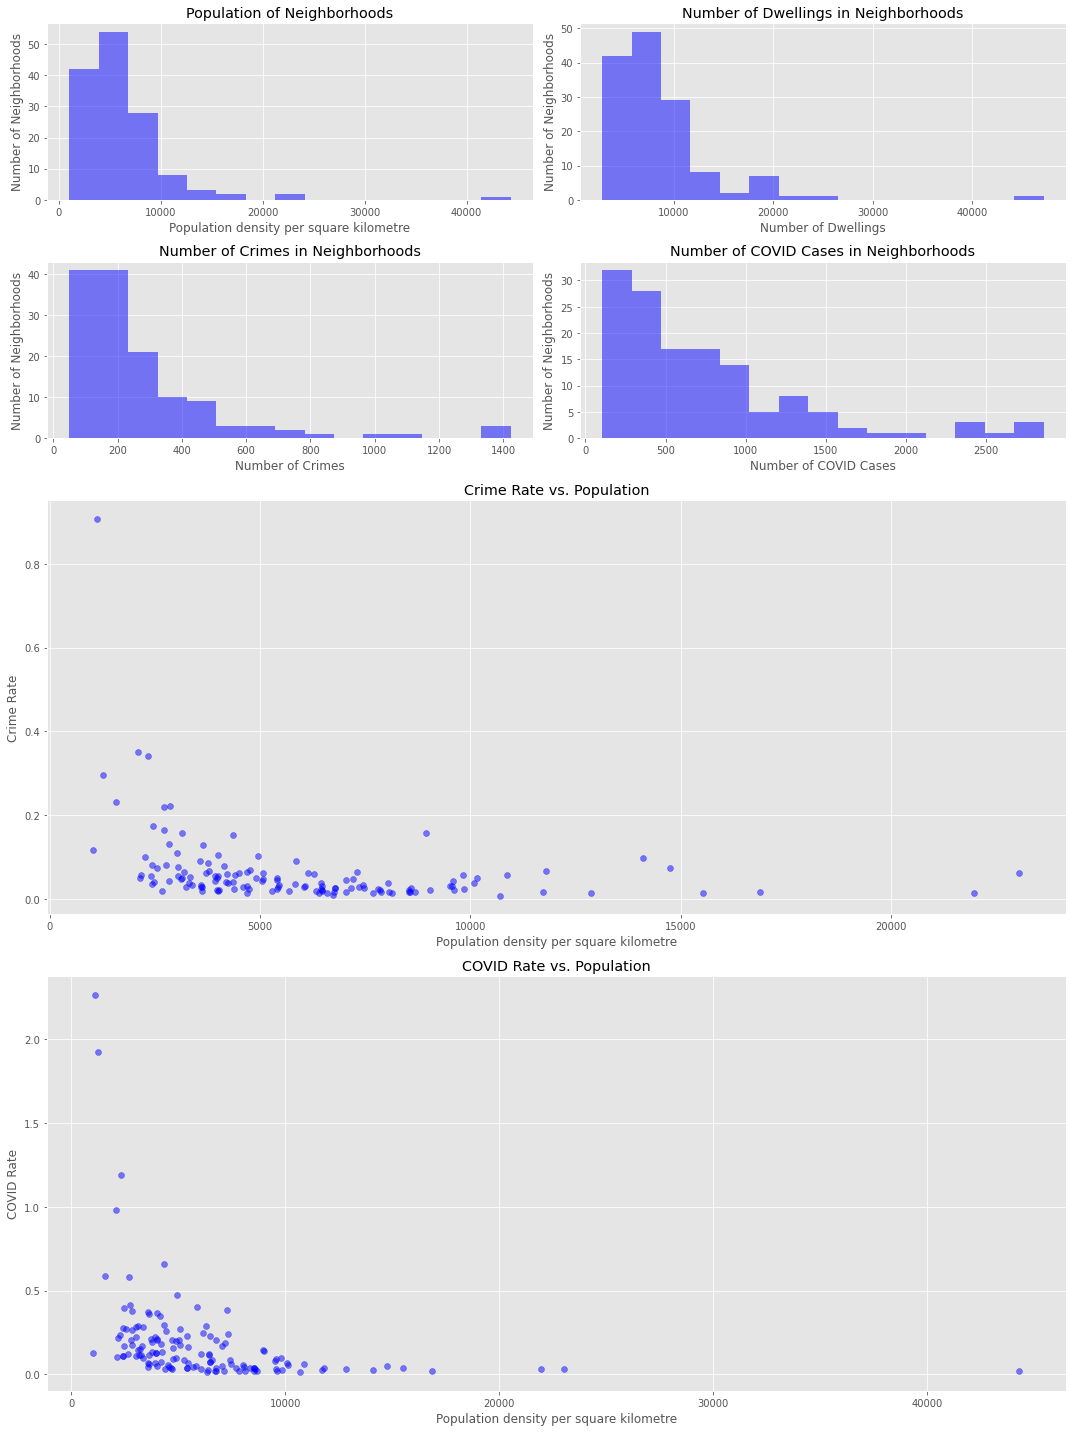

In [14]:
plt.style.use('ggplot')

Num_population = toronto_neighborhood_df.loc[:,"Population density per square kilometre"]
Num_dwellings = toronto_neighborhood_df.loc[:,"Total private dwellings"]
Num_crime = toronto_neighborhood_df.loc[:,"Crime Cases"]
Num_covid = toronto_neighborhood_df.loc[:,"COVID Cases"]
Rate_crime = toronto_neighborhood_df.loc[:,"Crime Rate"]
Rate_covid = toronto_neighborhood_df.loc[:,"COVID Rate"]

fig = plt.subplots(figsize = (15, 20), tight_layout=True)

ax1 = plt.subplot2grid((6, 2), (0, 0))
ax1.hist(Num_population, bins=15, color="b", alpha=0.5)
ax1.set(title="Population of Neighborhoods", xlabel="Population density per square kilometre", ylabel="Number of Neighborhoods")

ax2 = plt.subplot2grid((6, 2), (0, 1))
ax2.hist(Num_dwellings, bins=15, color="b", alpha=0.5)
ax2.set(title="Number of Dwellings in Neighborhoods", xlabel="Number of Dwellings", ylabel="Number of Neighborhoods")

ax3 = plt.subplot2grid((6, 2), (1, 0))
ax3.hist(Num_crime, bins=15, color="b", alpha=0.5)
ax3.set(title="Number of Crimes in Neighborhoods", xlabel="Number of Crimes", ylabel="Number of Neighborhoods")

ax4 = plt.subplot2grid((6, 2), (1, 1))
ax4.hist(Num_covid, bins=15, color="b", alpha=0.5)
ax4.set(title="Number of COVID Cases in Neighborhoods", xlabel="Number of COVID Cases", ylabel="Number of Neighborhoods")

ax5 = plt.subplot2grid((6, 2), (2, 0), colspan=2, rowspan=2)
ax5.scatter(Num_population, Rate_crime, color="b", alpha=0.5)
ax5.set(title="Crime Rate vs. Population", xlabel="Population density per square kilometre", ylabel="Crime Rate")

ax6 = plt.subplot2grid((6, 2), (4, 0), colspan=2, rowspan=2)
ax6.scatter(Num_population, Rate_covid, color="b", alpha=0.5)
ax6.set(title="COVID Rate vs. Population", xlabel="Population density per square kilometre", ylabel="COVID Rate")

plt.show()


#### Extract Foursquare data

In [17]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

#### Function for explore to all the neighborhoods

In [179]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [182]:
Neighborhood_names = toronto_neighborhood_df['Neighborhood'].tolist()
Neighborhood_lat = toronto_neighborhood_df['latitude'].tolist()
Neighborhood_lnt = toronto_neighborhood_df['longitude'].tolist()
Neighborhood_venues = getNearbyVenues(Neighborhood_names, Neighborhood_lat, Neighborhood_lnt, radius=1000)

Agincourt North
Agincourt South-Malvern West
Alderwood
Annex
Banbury-Don Mills
Bathurst Manor
Bay Street Corridor
Bayview Village
Bayview Woods-Steeles
Bedford Park
Beechborough
Bendale
Cliffside
Black Creek
Blake
Briar Hill
Sunnybrook
Broadview North
Amesbury
Cabbagetown-South St. James Town
Caledonia
Casa Loma
Centennial Scarborough
Church-Yonge Corridor
Clairlea
Clanton Park
Cliffcrest
Corso Italia-Davenport
Danforth
Danforth East York
Don Valley Village
Dorset Park
Dovercourt-Wallace Emerson-Junction
Roding
Dufferin Grove
East End-Danforth
Edenbridge-Humber Valley
Eglinton East
Elms-Old Rexdale
Englemount-Lawrence
Centennial
Etobicoke West Mall
Flemingdon Park
Forest Hill North
Forest Hill South
Glenfield
Greenwood
Guildwood
Henry Farm
High Park North
High Park-Swansea
Highland Creek
Hillcrest Village
Humber Heights-Westmount
Humber Summit
Emery
Humewood-Cedarvale
Ionview
Islington-City Centre West
Junction Area
Keelesdale-Eglinton West
Kennedy Park
Kensington
Kingsview Village
Kin

#### Take a look at the Data Extracted

In [183]:
print(Neighborhood_venues.shape)
Neighborhood_venues.head()

(6227, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt North,43.808038,-79.266439,Saravanaa Bhavan South Indian Restaurant,43.810117,-79.269275,Indian Restaurant
1,Agincourt North,43.808038,-79.266439,Menchie's,43.808338,-79.268288,Frozen Yogurt Shop
2,Agincourt North,43.808038,-79.266439,Samosa King - Embassy Restaurant,43.810152,-79.257316,Indian Restaurant
3,Agincourt North,43.808038,-79.266439,Shoppers Drug Mart,43.808894,-79.269854,Pharmacy
4,Agincourt North,43.808038,-79.266439,Booster Juice,43.809915,-79.269382,Juice Bar


In [186]:
Neighborhood_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt North,32,32,32,32,32,32
Agincourt South-Malvern West,65,65,65,65,65,65
Alderwood,22,22,22,22,22,22
Amesbury,26,26,26,26,26,26
Annex,100,100,100,100,100,100
Banbury-Don Mills,30,30,30,30,30,30
Bathurst Manor,17,17,17,17,17,17
Bay Street Corridor,82,82,82,82,82,82
Bayview Village,48,48,48,48,48,48


In [185]:
print('There are {} uniques categories.'.format(len(Neighborhood_venues['Venue Category'].unique())))

There are 339 uniques categories.


In [547]:
# one hot encoding
Neighborhood_onehot = pd.get_dummies(Neighborhood_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Neighborhood_onehot['Neighborhood'] = Neighborhood_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Neighborhood_onehot.columns[-1]] + list(Neighborhood_onehot.columns[:-1])
Neighborhood_onehot = Neighborhood_onehot[fixed_columns]

print(Neighborhood_onehot.shape)
Neighborhood_onehot.head()

Neighborhood_grouped = Neighborhood_onehot.groupby('Neighborhood').mean().reset_index()
Neighborhood_grouped.head()

(6227, 339)


,Neighborhood,Zoo,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shoppi

#### Top 10 venues of each neighborhood

In [546]:
num_top_venues = 10

for hood in Neighborhood_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Neighborhood_grouped[Neighborhood_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]   
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt North----
                       venue  freq
0         Chinese Restaurant  0.06
1          Indian Restaurant  0.06
2      Vietnamese Restaurant  0.03
3       Fast Food Restaurant  0.03
4         Dim Sum Restaurant  0.03
5        Japanese Restaurant  0.03
6            Thai Restaurant  0.00
7        Peruvian Restaurant  0.00
8          Korean Restaurant  0.00
9  Latin American Restaurant  0.00


----Agincourt South-Malvern West----
                      venue  freq
0       American Restaurant  0.03
1       Japanese Restaurant  0.02
2        Mexican Restaurant  0.02
3        Seafood Restaurant  0.02
4          Sushi Restaurant  0.02
5          Greek Restaurant  0.02
6        Chinese Restaurant  0.02
7      Caribbean Restaurant  0.02
8  Mediterranean Restaurant  0.02
9          Malay Restaurant  0.02


----Alderwood----
                        venue  freq
0         Moroccan Restaurant  0.05
1       Vietnamese Restaurant  0.00
2  Modern European Restaurant  0.00
3           Po

In [210]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [211]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Neighborhood_grouped['Neighborhood']

for ind in np.arange(Neighborhood_grouped.shape[0]):
     neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Neighborhood_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North,Coffee Shop,Bakery,Indian Restaurant,Bank,Chinese Restaurant,Park,Salon / Barbershop,Sandwich Place,Frozen Yogurt Shop,Beer Store
1,Agincourt South-Malvern West,Clothing Store,Restaurant,Gym / Fitness Center,Coffee Shop,Bakery,Bank,Sandwich Place,Gym,Department Store,American Restaurant
2,Alderwood,Pharmacy,Discount Store,Pizza Place,Convenience Store,Donut Shop,Shopping Mall,Park,Skating Rink,Liquor Store,Bagel Shop
3,Amesbury,Portuguese Restaurant,Fast Food Restaurant,Coffee Shop,Pizza Place,Supermarket,Breakfast Spot,Big Box Store,Park,Grocery Store,Bank
4,Annex,Café,Italian Restaurant,Korean Restaurant,Bakery,Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Grocery Store,Mexican Restaurant,Japanese Restaurant


#### Join the sorted venue DataFrame to the Neighborhood DataFrame

In [299]:
toronto_neighborhood_df_ana_pre = pd.merge(left=toronto_neighborhood_df, right=neighborhoods_venues_sorted, how='right', left_on='Neighborhood', right_on='Neighborhood')

print(toronto_neighborhood_df_ana_pre.shape)
toronto_neighborhood_df_ana_pre.head()

(140, 20)


,Neighborhood,Population,Total private dwellings,Population density per square kilometre,Crime Cases,COVID Cases,latitude,longitude,Crime Rate,COVID Rate,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North,29113.0,9371.0,3929.0,214.0,884.0,43.808038,-79.266439,0.054467,0.224994,Coffee Shop,Bakery,Indian Restaurant,Bank,Chinese Restaurant,Park,Salon / Barbershop,Sandwich Place,Frozen Yogurt Shop,Beer Store
1,Agincourt South-Malvern West,23757.0,8535.0,3034.0,329.0,685.0,43.781969,-79.257689,0.108438,0.225775,Clothing Store,Restaurant,Gym / Fitness Center,Coffee Shop,Bakery,Bank,Sandwich Place,Gym,Department Store,American Restaurant
2,Alderwood,12054.0,4732.0,2435.0,88.0,274.0,43.601717,-79.545232,0.036140,0.112526,Pharmacy,Discount Store,Pizza Place,Convenience Store,Donut Shop,Shopping Mall,Park,Skating Rink,Liquor Store,Bagel Shop
3,Amesbury,17757.0,6667.0,5045.0,212.0,1025.0,43.706162,-79.483492,0.042022,0.203171,Portuguese Restaurant,Fast Food Restaurant,Coffee Shop,Pizza Place,Supermarket,Breakfast Spot,Big Box Store,Park,Grocery Store,Bank
4,Annex,30526.0,18109.0,10863.0,604.0,654.0,43.670338,-79.407117,0.055602,0.060204,Café,Italian Restaurant,Korean Restaurant,Bakery,Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Grocery Store,Mexican Restaurant,Japanese Restaurant


#### Remove Neighborhoods with too few venues

As the main purpose is to find a neighborhood to open a restaurant. A neighborhood with too few features will be a sign of not being a suitable location. So, remove the neighborhoods with venues fewer than 15.


In [300]:
Neighborhood_fewVenue = Neighborhood_venues.groupby("Neighborhood")["Neighborhood"].agg('count').to_frame("Count").reset_index()
toronto_neighborhood_df_ana_pre = pd.merge(left=toronto_neighborhood_df_ana_pre, right=Neighborhood_fewVenue, how='left', left_on='Neighborhood', right_on='Neighborhood')

toronto_neighborhood_df_ana_pre = toronto_neighborhood_df_ana_pre[toronto_neighborhood_df_ana_pre["Count"] >= 15]

#Save it to csv for final analysis preparation
toronto_neighborhood_df_ana_pre.to_csv("joined_toronto_neighborhood_4final_analysis-a.csv")

print(toronto_neighborhood_df_ana_pre.shape)
toronto_neighborhood_df_ana_pre.head()

(119, 21)


,Neighborhood,Population,Total private dwellings,Population density per square kilometre,Crime Cases,COVID Cases,latitude,longitude,Crime Rate,COVID Rate,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Count
0,Agincourt North,29113.0,9371.0,3929.0,214.0,884.0,43.808038,-79.266439,0.054467,0.224994,Coffee Shop,Bakery,Indian Restaurant,Bank,Chinese Restaurant,Park,Salon / Barbershop,Sandwich Place,Frozen Yogurt Shop,Beer Store,32
1,Agincourt South-Malvern West,23757.0,8535.0,3034.0,329.0,685.0,43.781969,-79.257689,0.108438,0.225775,Clothing Store,Restaurant,Gym / Fitness Center,Coffee Shop,Bakery,Bank,Sandwich Place,Gym,Department Store,American Restaurant,65
2,Alderwood,12054.0,4732.0,2435.0,88.0,274.0,43.601717,-79.545232,0.036140,0.112526,Pharmacy,Discount Store,Pizza Place,Convenience Store,Donut Shop,Shopping Mall,Park,Skating Rink,Liquor Store,Bagel Shop,22
3,Amesbury,17757.0,6667.0,5045.0,212.0,1025.0,43.706162,-79.483492,0.042022,0.203171,Portuguese Restaurant,Fast Food Restaurant,Coffee Shop,Pizza Place,Supermarket,Breakfast Spot,Big Box Store,Park,Grocery Store,Bank,26
4,Annex,30526.0,18109.0,10863.0,604.0,654.0,43.670338,-79.407117,0.055602,0.060204,Café,Italian Restaurant,Korean Restaurant,Bakery,Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Grocery Store,Mexican Restaurant,Japanese Restaurant,100


In [302]:
toronto_Neighborhood_grouped_final = pd.merge(left=Neighborhood_grouped, right=Neighborhood_fewVenue, how='left', left_on='Neighborhood', right_on='Neighborhood')
toronto_Neighborhood_grouped_final = toronto_Neighborhood_grouped_final[toronto_Neighborhood_grouped_final["Count"] >= 15]
toronto_Neighborhood_grouped_final.to_csv("joined_toronto_neighborhood_4final_analysis-b.csv")

print(toronto_Neighborhood_grouped_final.shape)
toronto_Neighborhood_grouped_final.head()

(119, 340)


,Neighborhood,Zoo,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shoppi

#### Read the final analysis file back to save time

In [45]:
toronto_neighborhood_df_ana_pre = pd.read_csv("joined_toronto_neighborhood_4final_analysis-a.csv")
toronto_neighborhood_df_ana_pre = toronto_neighborhood_df_ana_pre.iloc[:,1:-1]

toronto_Neighborhood_grouped_final = pd.read_csv("joined_toronto_neighborhood_4final_analysis-b.csv")
toronto_Neighborhood_grouped_final = toronto_Neighborhood_grouped_final.iloc[:,1:-1]

print(toronto_Neighborhood_grouped_final.shape)
toronto_Neighborhood_grouped_final.head()

(119, 339)


,Neighborhood,Zoo,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shoppi

In [46]:
print(toronto_neighborhood_df_ana_pre.shape)
toronto_neighborhood_df_ana_pre.head()

(119, 20)


,Neighborhood,Population,Total private dwellings,Population density per square kilometre,Crime Cases,COVID Cases,latitude,longitude,Crime Rate,COVID Rate,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North,29113.0,9371.0,3929.0,214.0,884.0,43.808038,-79.266439,0.054467,0.224994,Coffee Shop,Bakery,Indian Restaurant,Bank,Chinese Restaurant,Park,Salon / Barbershop,Sandwich Place,Frozen Yogurt Shop,Beer Store
1,Agincourt South-Malvern West,23757.0,8535.0,3034.0,329.0,685.0,43.781969,-79.257689,0.108438,0.225775,Clothing Store,Restaurant,Gym / Fitness Center,Coffee Shop,Bakery,Bank,Sandwich Place,Gym,Department Store,American Restaurant
2,Alderwood,12054.0,4732.0,2435.0,88.0,274.0,43.601717,-79.545232,0.036140,0.112526,Pharmacy,Discount Store,Pizza Place,Convenience Store,Donut Shop,Shopping Mall,Park,Skating Rink,Liquor Store,Bagel Shop
3,Amesbury,17757.0,6667.0,5045.0,212.0,1025.0,43.706162,-79.483492,0.042022,0.203171,Portuguese Restaurant,Fast Food Restaurant,Coffee Shop,Pizza Place,Supermarket,Breakfast Spot,Big Box Store,Park,Grocery Store,Bank
4,Annex,30526.0,18109.0,10863.0,604.0,654.0,43.670338,-79.407117,0.055602,0.060204,Café,Italian Restaurant,Korean Restaurant,Bakery,Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Grocery Store,Mexican Restaurant,Japanese Restaurant


#### merge and clean the analysis dataframe

In [47]:
toronto_Neighborhood_4_kmeanAnalysis = pd.merge(left=toronto_Neighborhood_grouped_final, right=toronto_neighborhood_df_ana_pre, how='left', left_on='Neighborhood', right_on='Neighborhood')
toronto_Neighborhood_4_kmeanAnalysis['Crime Rate'] = toronto_Neighborhood_4_kmeanAnalysis['Crime Rate'].fillna(0)
toronto_Neighborhood_4_kmeanAnalysis['COVID Rate'] = toronto_Neighborhood_4_kmeanAnalysis['COVID Rate'].fillna(0)

toronto_Neighborhood_4_kmeanAnalysis = toronto_Neighborhood_4_kmeanAnalysis.iloc[:,0:-10]
toronto_Neighborhood_4_kmeanAnalysis = toronto_Neighborhood_4_kmeanAnalysis[[col for col in toronto_Neighborhood_4_kmeanAnalysis.columns if col != "Population" and col != "Crime Cases" and col != "COVID Cases" and col != "latitude" and col != "longitude" and col != "longiitude" and col != "Count"]]

toronto_Neighborhood_4_kmeanAnalysis.head()

,Neighborhood,Zoo,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shoppi

#### Normalize Population and Dwelling Number

In [51]:
from sklearn.preprocessing import MinMaxScaler

Dwelling_scaled = toronto_Neighborhood_4_kmeanAnalysis[["Total private dwellings", "Population density per square kilometre", "Crime Rate", "COVID Rate"]]

Dwelling_scaled = MinMaxScaler().fit_transform(Dwelling_scaled)

Dwelling_scaled = pd.DataFrame(Dwelling_scaled)

toronto_Neighborhood_4_kmeanAnalysis["Total private dwellings"] = Dwelling_scaled[0]
toronto_Neighborhood_4_kmeanAnalysis["Population density per square kilometre"] = Dwelling_scaled[1]
toronto_Neighborhood_4_kmeanAnalysis["Crime Rate"] = Dwelling_scaled[2]
toronto_Neighborhood_4_kmeanAnalysis["COVID Rate"] = Dwelling_scaled[3]

print(toronto_Neighborhood_4_kmeanAnalysis.shape)
toronto_Neighborhood_4_kmeanAnalysis.head()

(119, 343)


,Neighborhood,Zoo,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shoppi

#### Cluster Analysis

In [52]:
from sklearn.cluster import KMeans

# set number of clusters to check first
kclusters = 4

Neighborhood_grouped_clustering = toronto_Neighborhood_4_kmeanAnalysis.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Neighborhood_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 3, 0, 0, 3, 0, 0])

Search for the best kclusters

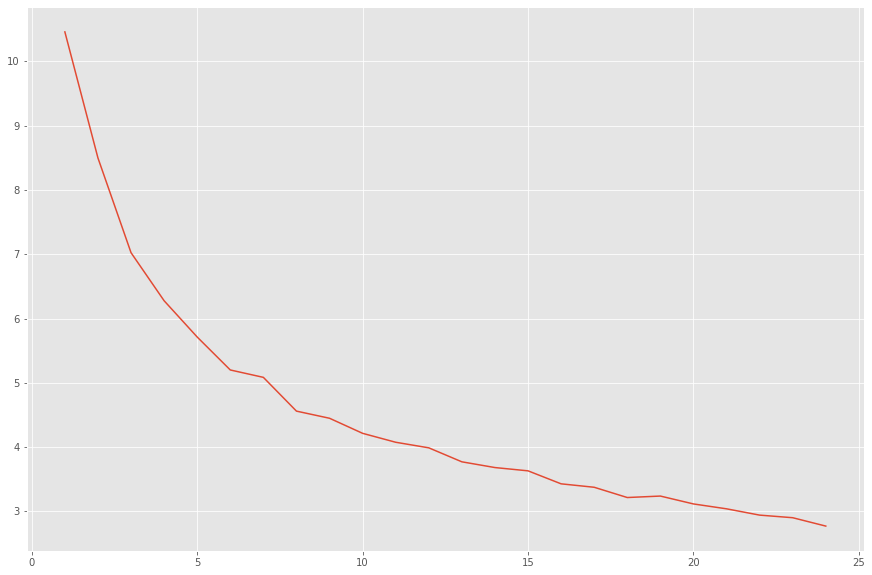

In [53]:
Ks = range(1, 25)

distortions = []
for i in Ks:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(Neighborhood_grouped_clustering)
    distortions.append(km.inertia_)
    

fig, ax = plt.subplots(figsize=(15,10))
ax.plot([i for i in Ks], distortions);

So, it can been seen that the elbow is at kcluster=7

#### Do it again for kcluster=7

In [54]:
# set number of clusters to check first
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Neighborhood_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 5, 5, 5, 3, 2, 5, 3, 0, 5])

#### Append the lables to the DataFrame

In [55]:
#merge the latitudes and longtitudes backed to the Dataframe
neighbor_lat_lnt = pd.read_csv("joined_toronto_neighborhood.csv")
neighbor_lat_lnt = neighbor_lat_lnt[["Neighborhood", "latitude", "longitude"]]
toronto_Neighborhood_4_kmeanAnalysis = pd.merge(left=toronto_Neighborhood_4_kmeanAnalysis, right=neighbor_lat_lnt, how='left', left_on='Neighborhood', right_on='Neighborhood')

#Append the Clusters
toronto_Neighborhood_4_kmeanAnalysis["Cluster"] = kmeans.labels_
toronto_Neighborhood_4_kmeanAnalysis.head()

,Neighborhood,Zoo,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shoppi

#### Sort by using the clusters

In [56]:
toronto_Neighborhood_4_kmean_grouped_Analysis = toronto_Neighborhood_4_kmeanAnalysis.groupby("Cluster").mean().reset_index()

toronto_Neighborhood_4_kmean_grouped_Analysis

,Cluster,Zoo,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Pl

#### Just check the clusters with mean for restaurant

In [57]:
Cluster_COL = [col for col in toronto_Neighborhood_4_kmeanAnalysis.columns if 'Restaurant' in col and col != "Restaurant"]

Cluster_COL = list([toronto_Neighborhood_4_kmeanAnalysis.columns[-1]]) + Cluster_COL + list(toronto_Neighborhood_4_kmeanAnalysis.columns[-7:-3])

toronto_Neighborhood_4_kmeanAnalysis_FinalTable = toronto_Neighborhood_4_kmean_grouped_Analysis[Cluster_COL]

toronto_Neighborhood_4_kmeanAnalysis_FinalTable

,Cluster,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Doner Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hawaiian Restaurant,Hong Kong Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Seafood Restaurant,South American Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total private dwellings,Population density per square kilometre,Crime Rate,COVID Rate
0,0,0.000000,0.000000,0.008595,0.000458,0.006538,0.000169,0.000987,0.000769,0.000646,0.003945,0.009198,0.000169,0.001199,0.00000,0.000253,0.000339,0.000000,0.000604,0.000678,0.000169,0.001606,0.003927,0.015354,0.000903,0.004254,0.000368,0.000326,0.007092,0.000169,0.00000,0.000682,0.000169,0.008953,0.000555,0.027695,0.010793,0.001238,0.007059,0.002747,0.000000,0.005323,0.010487,0.008088,0.000371,0.000000,0.001369,0.00081,0.000862,0.000169,0.00,0.002928,0.003521,0.003446,0.001884,0.000169,0.000000,0.019932,0.000000,0.000169,0.000339,0.001525,0.000169,0.011538,0.000169,0.000691,0.001728,0.000265,0.006877,0.006158,0.076997,0.142593,0.027526,0.022933
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.185734,0.001779,1.000000,1.000000
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.062083,0.000000,0.000000,0.00000,0.008333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028750,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.018519,0.000000,0.017593,0.008333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.009259,0.010417,0.009259,0.000000,0.000000,0.000000,0.000000,0.000000,0.009259,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.288103,0.082975,0.056532,0.094764
3,3,0.000000,0.001182,0.006700,0.000000,0.002222,0.000000,0.000000,0.000000,0.000000,0.002222,0.005731,0.000000,0.001111,0.00000,0.000000,0.000000,0.000000,0.001111,0.002222,0.000000,0.000000,0.003367,0.010561,0.000000,0.005556,0.001111,0.000000,0.003333,0.000000,0.00000,0.000000,0.000000,0.009436,0.002525,0.047312,0.017787,0.001111,0.006738,0.001111,0.000000,0.001355,0.011358,0.015006,0.001111,0.000000,0.002222,0.00000,0.000000,0.000000,0.00,0.002364,0.010760,0.006970,0.000000,0.000000,0.000000,0.018809,0.000000,0.000000,0.000000,0.0000

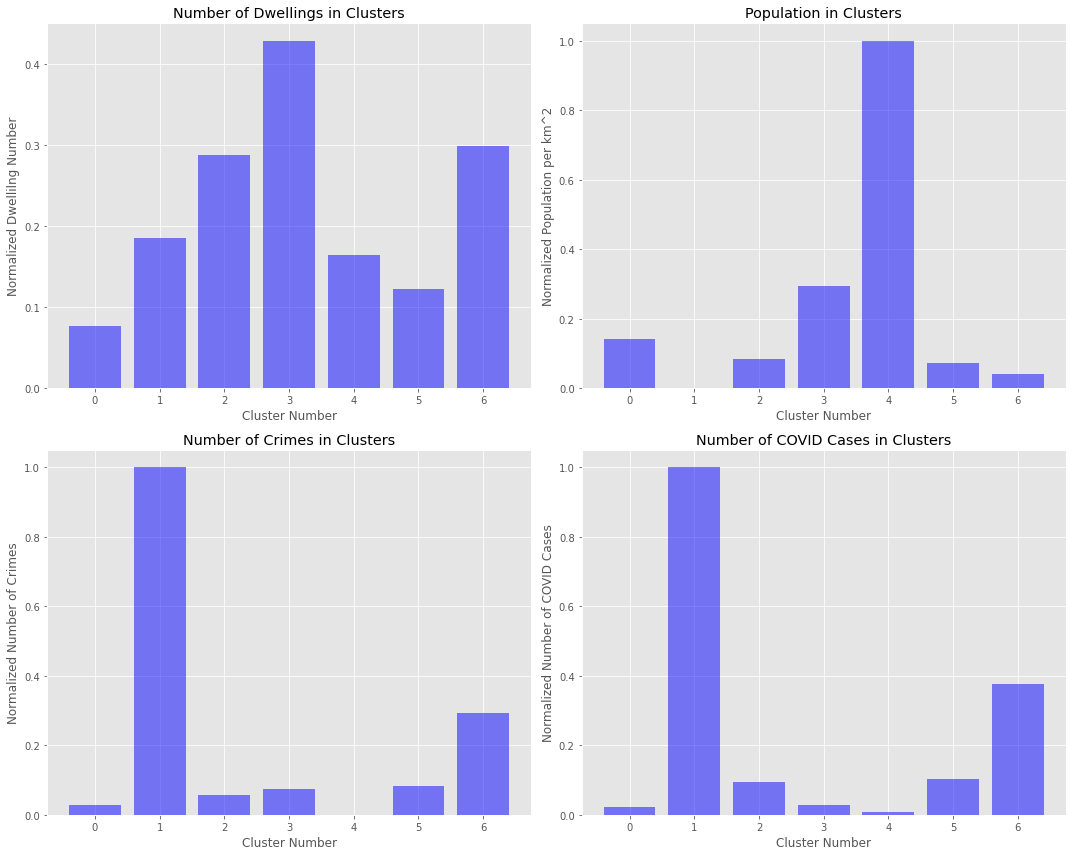

In [58]:
dwell_chart = toronto_Neighborhood_4_kmeanAnalysis_FinalTable["Total private dwellings"]
Popu_chart = toronto_Neighborhood_4_kmeanAnalysis_FinalTable["Population density per square kilometre"]
Crime_chart = toronto_Neighborhood_4_kmeanAnalysis_FinalTable["Crime Rate"]
COVID_chart = toronto_Neighborhood_4_kmeanAnalysis_FinalTable["COVID Rate"]
Chart_index = toronto_Neighborhood_4_kmeanAnalysis_FinalTable.index.values

fig = plt.figure(figsize = (15, 12), tight_layout=True)

ax1 = fig.add_subplot(221)
ax1.bar(Chart_index, dwell_chart, color="b", alpha=0.5)
ax1.set(title="Number of Dwellings in Clusters", xlabel="Cluster Number", ylabel="Normalized Dwellilng Number")

ax2 = fig.add_subplot(222)
ax2.bar(Chart_index, Popu_chart, color="b", alpha=0.5)
ax2.set(title="Population in Clusters", xlabel="Cluster Number", ylabel="Normalized Population per km^2")

ax3 = fig.add_subplot(223)
ax3.bar(Chart_index, Crime_chart, color="b", alpha=0.5)
ax3.set(title="Number of Crimes in Clusters", xlabel="Cluster Number", ylabel="Normalized Number of Crimes")

ax4 = fig.add_subplot(224)
ax4.bar(Chart_index, COVID_chart, color="b", alpha=0.5)
ax4.set(title="Number of COVID Cases in Clusters", xlabel="Cluster Number", ylabel="Normalized Number of COVID Cases")
plt.show()

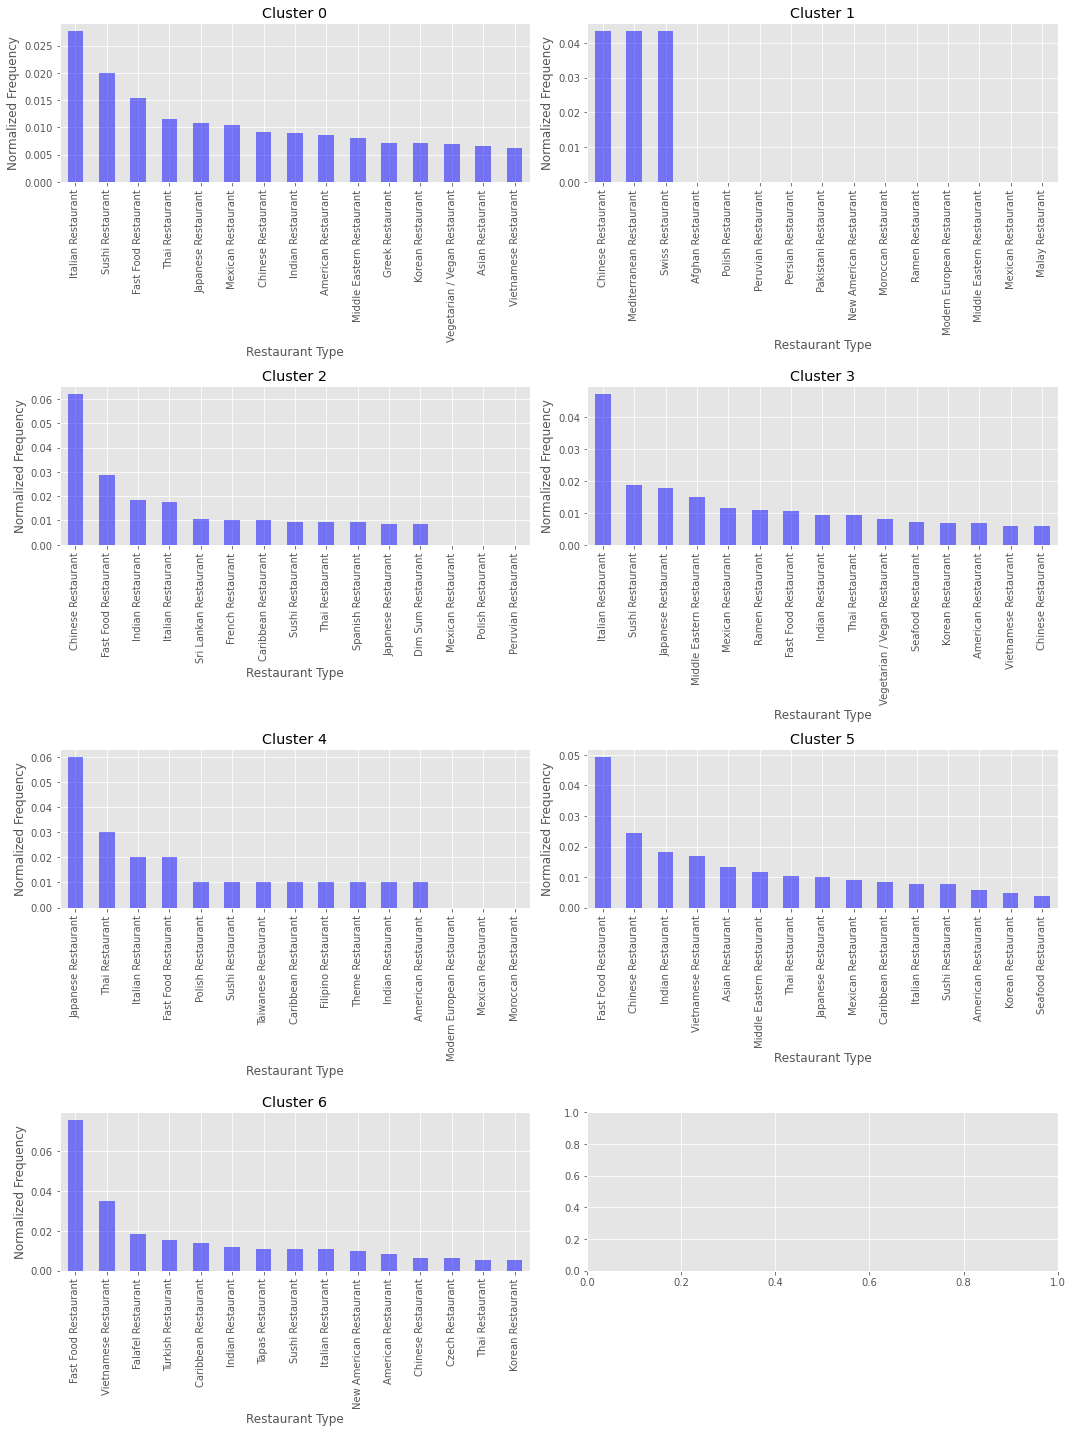

In [61]:
fig, axes = plt.subplots(4, 2, figsize = (15, 20), tight_layout=True)

for i in range(0,4):
    for j in range(0,2):
        clu_num = i * 2 + j
        if i < 3:
            Height_bar = toronto_Neighborhood_4_kmeanAnalysis_FinalTable.iloc[clu_num,1:-4]
            Height_bar = Height_bar.sort_values(ascending=False)
            Height_bar = Height_bar.iloc[0:15]
            Height_bar.plot.bar(ax=axes[i,j], color='b', alpha = 0.5, title="Cluster " + str(clu_num), xlabel="Restaurant Type", ylabel="Normalized Frequency")
        else:
            if j == 0:
                Height_bar = toronto_Neighborhood_4_kmeanAnalysis_FinalTable.iloc[clu_num,1:-4]
                Height_bar = Height_bar.sort_values(ascending=False)
                Height_bar = Height_bar.iloc[0:15]
                Height_bar.plot.bar(ax=axes[i,j], color='b', alpha = 0.5, title="Cluster " + str(clu_num), xlabel="Restaurant Type", ylabel="Normalized Frequency")                

plt.show()

#### Visualize the results on the map

In [67]:
geolocator = Nominatim(user_agent="toronto_agent")
toronto_location = geolocator.geocode("Toronto")

latitude = toronto_location.latitude
longitude = toronto_location.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_Neighborhood_4_kmeanAnalysis['latitude'], toronto_Neighborhood_4_kmeanAnalysis['longitude'], toronto_Neighborhood_4_kmeanAnalysis['Neighborhood'], toronto_Neighborhood_4_kmeanAnalysis['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Final Thought

From the above results, it can been seen that Cluster 4 is of the highest population density, lowest number of COVID-19 Cases and crime rate. This is probably the location to open a new restaurant. For the type of restaurant to be opene, there can be two schools of thoughts. Some individuals may believe it is better to go for the type which is already quite popular in the neighborhood. To this end, they may go for the idea of opening a Japanese restaurant. On the contrary, some people may think that it is better to start a restaurant which sells food which is not yet presented in the neighborhood. A maxican restaurant could be a choice in this case.